# Krótki wstęp wprowadzający

W notatniku zawarto wstępną analizę eksploracyjną danych (EDA), mającą na celu zapoznanie się z rozkładem recenzji oraz ich cechami. Na tej podstawie przechodzimy do analizy za pomocą metod NLP, gdzie celem jest klasyfikacja recenzji jako negatywne (0) lub pozytywne (1), bazując na dostępnych danych treningowych. Wykorzystano tutaj cztery modele do klasyfikacji tekstów przy użyciu sieci neuronowych.

Modele:
- Model 0 (Pipeline) – wykorzystano klasyczny pipeline z TfidfVectorizer oraz Logistic Regression, co pozwala na stworzenie efektywnego klasyfikatora przy standardowej metodzie przetwarzania tekstu.

- Model 1 (Char-level CNN z embeddingiem) – W tym modelu teksty są najpierw przetwarzane przez TextVectorizer, który zamienia je na wektory o stałej długości, a następnie przechodzą przez embedding, który mapuje je na gęste wektory o 128 wymiarach. Następnie dane przechodzą przez warstwę konwolucyjną Conv1D (64 filtry o długości 5), której zadaniem jest wykrywanie lokalnych wzorców w sekwencjach znaków. Warstwa GlobalAveragePooling1D redukuje sekwencje do jednej reprezentacji, a na końcu następuje klasyfikacja binarna przy pomocy warstwy Dense z aktywacją sigmoid. (sigmoid na wyjściu bo mamy tylko dwie klasy)To podejście jest bardziej złożone i pozwala na lepsze wychwytywanie zależności w obrębie tekstu.

- Model 2 (Sentence Encoder) – użyty został sentence encoder z TensorFlow Hub, który przekształca całe zdania w wektory, a następnie za pomocą warstw gęstych wykonuje klasyfikację. Model ten bazuje na potężnej architekturze pretreningowej, co umożliwia wydobycie semantycznych reprezentacji całych zdań.

- Model 3 (Char-level CNN) – zastosowano podejście char-level, gdzie teksty są analizowane na poziomie pojedynczych znaków. Dzięki warstwom char_vectorizer, char_embed oraz Conv1D, model jest w stanie rozpoznać wzorce na poziomie liter i znaków, co jest przydatne w przypadku nieregularnych tekstów, np. z błędami ortograficznymi.

- Model 4 (Char-level + Token-level CNN) – ten model łączy podejście char-level z token-level, tworząc połączenie cech wykrytych na poziomie znaków oraz słów. Dzięki temu może uchwycić bardziej złożone zależności między znakami a słowami w kontekście klasyfikacji.

- Kolejne etapy:
 Po przeanalizowaniu skuteczności modeli klasyfikacji recenzji, przeszliśmy do tworzenia podsumowań (Summary), wykorzystując podejście generacyjne do streszczania recenzji, co ma na celu redukcję długości recenzji przy zachowaniu kluczowych informacji.

 Na koniec przeprowadzono analizę KMeans, aby pogrupować recenzje tematycznie. Dzięki temu można było zidentyfikować różne tematyki i tendencje w recenzjach, co pozwoliło na lepsze zrozumienie danych i ich struktury.

- Wnioski:
 Po przeanalizowaniu wyników różnych modeli klasyfikacyjnych, zauważono, że Pipeline z TfidfVectorizer oraz Logistic Regression uzyskał najlepsze rezultaty, mimo iż inne modele również dały dobre wyniki. Szczególnie interesujący okazał się model 4, który łączył podejście na poziomie znaków (char) oraz tokenów, osiągając również wysoką skuteczność w klasyfikacji recenzji.

In [ ]:
import kagglehub
path = kagglehub.dataset_download("arhamrumi/amazon-product-reviews")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/amazon-product-reviews


In [ ]:
import os
files = os.listdir(path)
print("Zawartość folderu:", files)

Zawartość folderu: ['Reviews.csv']


# Wczytuję dane zawierające tekst i podsumomwanie - summary

In [ ]:
import pandas as pd
df = pd.read_csv(f"{path}/Reviews.csv")
df.shape

(568454, 10)

In [ ]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# EDA - ile recenzji ma każdy user

In [ ]:
df['ProfileName'].value_counts()

,count
ProfileName,
"C. F. Hill ""CFH""",451
"O. Brown ""Ms. O. Khannah-Brown""",421
Gary Peterson,389
"Rebecca of Amazon ""The Rebecca Review""",365
Chris,363
...,...
Steven Wolff,1
joycomeau,1
Lizz,1


# Najczęstrze oceny


Text(0.5, 1.0, 'Percentege of ratings')

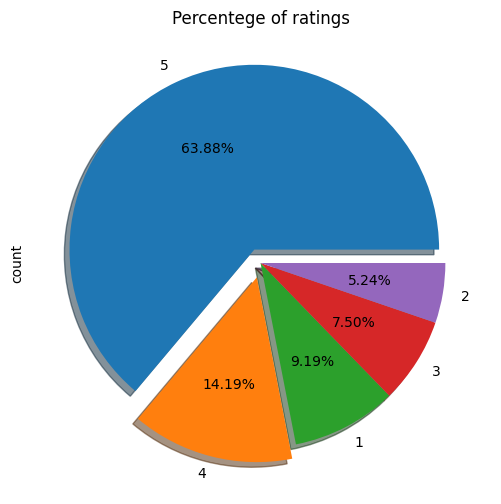

In [ ]:
import matplotlib.pyplot as plt
explode = 2 * (0.08, ) + 3 * (0, )
df['Score'].value_counts().plot.pie(autopct='%1.2f%%', figsize=(10, 6), explode=explode, shadow=True)
plt.title('Percentege of ratings')


In [ ]:
# nie ma duplikatów
df[df.duplicated()]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text


# Zmieniam format daty, być może przyda się on w dalszych analizach

In [ ]:
df['Date'] = pd.to_datetime(df['Time'], unit='s')
df['Year'] = df['Date'].dt.year
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Date,Year
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,2011
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,2012
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,2008
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,2011
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,2012
...,...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,2011-03-09,2011
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,2012-03-09,2012
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",2012-02-21,2012
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,2012-03-13,2012


# W którym roku najwięcej recenzji

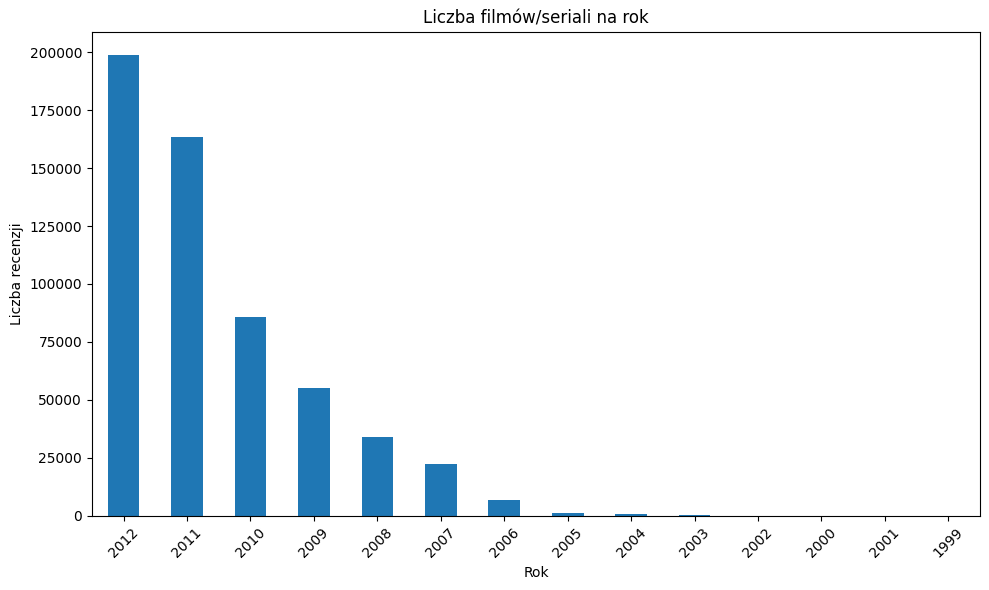

In [ ]:
df_year = df['Year'].value_counts().reset_index(name='count')
df_year.columns = ['year', 'count']
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
df_year['count'].plot(kind='bar', ax=ax)
ax.set_xticklabels(df_year['year'].unique(), rotation=45)
ax.set_title("Liczba filmów/seriali na rok")
ax.set_xlabel("Rok")
ax.set_ylabel("Liczba recenzji")
plt.tight_layout()
plt.show()

In [ ]:
df['Summary'].unique().size

295743

# Czy uznana za pomocną

##Tworzę pewnego rodzaju zmienną, która będzie mierzyć w jakiś sposób czy dana recenzja uznana jest za pomocną, czy też nie jest uznana za pomocną

In [ ]:
df_copy = df[df['HelpfulnessDenominator'] > 0]  # uniknij dzielenia przez 0
df_copy['is_helpful'] = (df_copy['HelpfulnessNumerator'] / df_copy['HelpfulnessDenominator']) > 0.6
df_copy['is_helpful'] = df_copy['is_helpful'].astype(int)  # binary: 0 / 1

<ipython-input-14-d3d290e6c6ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['is_helpful'] = (df_copy['HelpfulnessNumerator'] / df_copy['HelpfulnessDenominator']) > 0.6
<ipython-input-14-d3d290e6c6ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy['is_helpful'] = df_copy['is_helpful'].astype(int)  # binary: 0 / 1


# Czy pozytywna recenzja

In [ ]:
# Score ≤ 2 → negatywny (0)
# Score ≥ 4 → pozytywny (1)
# 3 neutralna
df_copy_2 = df[df['Score'] != 3]
df_copy_2['Sentiment'] =  df_copy_2['Score'].apply(lambda x: 1 if x > 3 else 0)
df_copy_2

<ipython-input-15-d218dad1095e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_copy_2['Sentiment'] =  df_copy_2['Score'].apply(lambda x: 1 if x > 3 else 0)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Date,Year,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,2011,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,2012,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,2008,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,2011-06-13,2011,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,2012-10-21,2012,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,2011-03-09,2011,1
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...,2012-03-09,2012,0
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",2012-02-21,2012,1
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...,2012-03-13,2012,1


# Model który przewiduje wystawioną ocene

In [ ]:
# Brak balansu - Model może mieć tendencję do przewidywania 5 dlatego lepiej zmienić to na dwie klasy - ocena pozytywna i negatywna

df['Score'].value_counts()

,count
Score,
5,363122
4,80655
1,52268
3,42640
2,29769


## Chciałem tu na początku przewidzieć ocenę na podstawie już posiadanych danych treningowych jednak dane te nie są zbalansowane, więc uznałem, że lepiej bedzie się zająć przewidywaniem innej rzeczy

In [ ]:
from tensorflow.keras.layers import TextVectorization, Embedding
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
import tensorflow as tf
print(tf.__version__)


2.15.0


# A więc na podstawie kryterium oceny podzieliłem to na binarny zbiór 0 i 1, gdzie 1 to pozytywna a 0 to negatywna ocena . 3 nie uwzględniałem jako ta ocena neutralna
- Score ≤ 2 → negatywny (0)
- Score ≥ 4 → pozytywny (1)

In [ ]:
df_copy_2['Sentiment'].value_counts()

,count
Sentiment,
1,443777
0,82037


In [ ]:
df_train_list = df_copy_2['Text'].to_list()
df_label_list = df_copy_2['Sentiment'].to_list()


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train_list,
    df_label_list,
    test_size=0.2,
    random_state=42
)

# Model_0 - Pipeline

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-05-02 18:46:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-05-02 18:46:40 (21.0 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



# Pipeline
Ten pipeline tworzy prosty, ale skuteczny model klasyfikacji tekstu (np. do analizy sentymentu recenzji):

TfidfVectorizer() – przekształca teksty w numeryczne wektory cech, uwzględniając częstość słów i ich unikalność w korpusie (TF-IDF).

LogisticRegression(class_weight='balanced', max_iter=1000) – klasyfikator logistyczny, który:

używa ważenia klas balanced, co oznacza, że model automatycznie dostosowuje wagi klas, aby radzić sobie z niezrównoważonymi danymi (np. dużo więcej recenzji pozytywnych niż negatywnych),

max_iter=1000 zapewnia wystarczającą liczbę iteracji do zbieżności modelu.

In [ ]:
from helper_functions import calculate_results

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression



# Trzeba uwzględnić balanced bo inaczej będzie działać, przewidując cały czas 1

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000))
])

In [ ]:
model_0.fit(
    X_train, y_train
)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [ ]:
model_0.score(X_test, y_test)

0.9160636345482727

In [ ]:
baseline_preds = model_0.predict(X_test)
baseline_preds



array([1, 1, 1, ..., 1, 0, 1])

In [ ]:
import pandas as pd
pd.DataFrame(baseline_preds).value_counts()

,count
0,
1,82741
0,22422


In [ ]:
pd.DataFrame(y_test).value_counts()

,count
0,
1,88784
0,16379


In [ ]:
baseline_results = calculate_results(
    y_true=y_test,
    y_pred=baseline_preds
)
baseline_results

{'accuracy': 91.60636345482726,
 'precision': 0.9341513408310241,
 'recall': 0.9160636345482727,
 'f1': 0.9211213206695362}

Jak widzimy wysoka skuteczność modelu. Z reguły ciężko jest przebić Pipeline innymi modelami już przez nas tworzonymi (posiadającymi naszą architekturę)

In [ ]:
import matplotlib.pyplot as plt


(array([4.06915e+05, 1.19740e+04, 1.23800e+03, 3.91000e+02, 8.40000e+01,
        2.70000e+01, 1.40000e+01, 3.00000e+00, 4.00000e+00, 1.00000e+00]),
 array([   3. ,  254.7,  506.4,  758.1, 1009.8, 1261.5, 1513.2, 1764.9,
        2016.6, 2268.3, 2520. ]),
 <BarContainer object of 10 artists>)

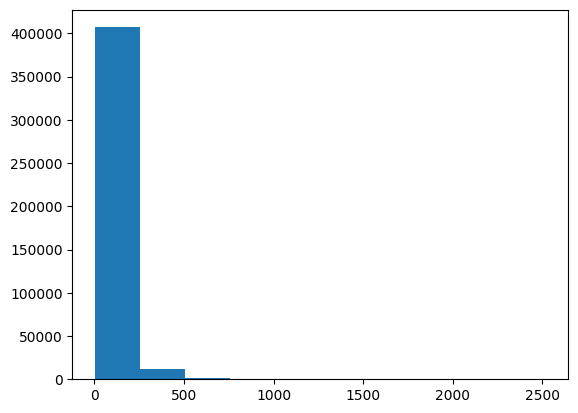

In [ ]:
train_text = [len(x.split()) for x in X_train]
val_text = [len(x.split()) for x in X_test]
plt.hist(train_text)

Każde zdanie rozbijam na wyrazy i liczę ile ma słów . Potem robię histogram, po to żeby zbadać przy jakim progu osiągamy 95 % danych, będzie nam to potrzebne po to żeby wprowadzać to jako `output_sequence_length` w funkcji `TextVectorization`.

In [ ]:
import numpy as np
sequence_length = int(np.percentile(train_text, 95))
sequence_length

215

# Build model with text_vectorizer + embedding + Conv1D

# Po co?
Ten komponent służy do przekształcania surowego tekstu (np. recenzji) w ciągi liczb, które mogą być przetwarzane przez modele uczenia maszynowego i sieci neuronowe.

- max_tokens=30000

 Tworzy słownik z maksymalnie 30 000 najczęściej występujących słów w zbiorze danych.
 Każde słowo otrzymuje swój unikalny numer (indeks).

 Rzadkie słowa (poza top 30k) są mapowane na specjalny token "out-of-vocabulary" (OOV).

- output_mode='int'

 Tekst wejściowy (np. "This product is great!") zostaje zamieniony na ciąg liczb, np. [15, 682, 8, 3041], gdzie każda liczba to indeks słowa w słowniku.

- output_sequence_length=sequence_length

 Każde zdanie jest przekształcane do stałej długości (np. 215 tokenów):

 Jeśli zdanie jest krótsze, zostanie dopełnione zerami.

 Jeśli zdanie jest dłuższe, zostanie ucięte.

In [ ]:
text_vectorizer = TextVectorization(
    max_tokens=30000,
    output_mode='int',
    output_sequence_length=sequence_length
)  # sequence_len = 215



In [ ]:
import pandas as pd
subset = pd.DataFrame(X_train).sample(frac=0.05, random_state=42)
subset.columns = ['val']
subset
subset = subset['val'].to_list()

# Dostosowujemy nasz `TextVectorization` do zdań w zbiorze danych

In [ ]:
text_vectorizer.adapt(subset)

In [ ]:
input_dim = len(text_vectorizer.get_vocabulary())
input_dim  # 227759

30000

In [ ]:
embeddings = Embedding(
  input_dim=input_dim,
  output_dim=128,
  embeddings_initializer='uniform'
)

# Po co `Embedding` ?  
Ta warstwa służy do zamiany liczb całkowitych (indeksów słów) na wektory o stałym rozmiarze – tzw. osadzenia (embeddings).

- input_dim=input_dim

  To rozmiar słownika, czyli liczba unikalnych słów (tokenów), które pojawiły się w danych.

  Zazwyczaj ustawiamy to na taką samą wartość jak max_tokens z TextVectorization (np. 30 000).

- output_dim=128

  Każde słowo zostaje zamienione na wektor o 128 wymiarach (czyli np. [0.12, -0.08, ..., 0.91]).

  Te wektory reprezentują znaczenie słowa w przestrzeni semantycznej, tak by podobne słowa miały podobne wektory.

- embeddings_initializer='uniform'

  Wektory są na początku losowo inicjalizowane z rozkładu jednostajnego.

  Następnie model uczy się ich wartości podczas treningu, aby lepiej reprezentowały zależności między słowami.

In [ ]:
embedding_size_rule = int(np.sqrt(input_dim))
embedding_size_rule

173

# Model 1

- Model model_1 – Klasyfikator tekstu z CNN

 Ten model to sieć neuronowa do klasyfikacji tekstu (np. analiza sentymentu), która przetwarza teksty za pomocą konwolucji 1D (CNN). Oto przegląd działania:

In [ ]:
import tensorflow as tf
inputs = tf.keras.layers.Input(shape=(1, ), dtype=tf.string)
x = text_vectorizer(inputs)
x = embeddings(x)
print(x.shape)
x = tf.keras.layers.Conv1D(64, 5, activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
print(x.shape)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs, outputs)


(None, 215, 128)
(None, 64)


In [ ]:
model_1.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

# Po co to ?
- tf.data.Dataset.from_tensor_slices(...)

 Tworzy obiekt Dataset, który łączy dane wejściowe (X) z etykietami (y).

 Dzięki temu można łatwo przekazać dane do modelu w sposób zoptymalizowany.

- .batch(32)

 Grupuje dane w batch'e po 32 próbki, co przyspiesza trenowanie i stabilizuje gradienty.

 Batch size = 32 to standardowy, dobrze działający wybór.

- .prefetch(tf.data.AUTOTUNE)

 Pozwala na równoległe przygotowywanie kolejnych batchy w tle, podczas gdy model trenuje na bieżącym batchu.

- AUTOTUNE automatycznie wybiera najlepszą liczbę elementów do pobrania z    wyprzedzeniem – optymalizacja wydajności.

# Podsumowanie, używamy tego aby

- przyspieszyć trening,

- zaoszczędzić pamięć,

- automatycznie podawać dane do modelu w optymalny sposób,

- mieć elastyczne i skalowalne rozwiązanie.

In [ ]:
from sklearn.utils import class_weight
import numpy as np

weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(y_train),
                                            y=y_train
                                            )
class_weights = dict(zip(np.unique(y_train), weights))
class_weights


{0: 3.2033491729872976, 1: 0.592477879845518}

Ten kod automatycznie oblicza wagi klas, co jest przydatne, gdy dane treningowe są nierównomiernie rozłożone (np. 90% pozytywnych i tylko 10% negatywnych etykiet).

Bez takiego zrównoważenia model może ignorować rzadką klasę i uczyć się tylko tej dominującej.

# Trenujemy nasz model ale tylko na 5% danych walidacyjnych, ponieważ jest ich dużo

In [ ]:
model_1.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=int(0.05 * len(train_dataset)),
    validation_steps=int(0.05 * len(val_dataset)),
    epochs=3,
    class_weight=class_weights
)

Epoch 1/3
657/657 [==============================] - 71s 107ms/step - loss: 0.4494 - accuracy: 0.8260 - val_loss: 0.3521 - val_accuracy: 0.8683
Epoch 2/3
657/657 [==============================] - 84s 128ms/step - loss: 0.3279 - accuracy: 0.8763 - val_loss: 0.4314 - val_accuracy: 0.8337
Epoch 3/3
657/657 [==============================] - 85s 130ms/step - loss: 0.3023 - accuracy: 0.8862 - val_loss: 0.5546 - val_accuracy: 0.7967


In [ ]:
# !pip install tensorflow==2.15
import tensorflow as tf
tf.__version__

'2.15.0'

# Model 2

Model model_2 – Klasyfikator tekstu z gotowym encoderem semantycznym (USE)
Ten model wykorzystuje pretrenowany model językowy z TensorFlow Hub – Universal Sentence Encoder (USE) – do zamiany całych zdań na semantyczne wektory liczbowe, które są następnie używane do klasyfikacji binarnej



In [ ]:
import tensorflow_hub as hub
tf_hub_sentence_encoder = hub.KerasLayer(
    'https://tfhub.dev/google/universal-sentence-encoder/4',
    trainable=False,
    dtype='string',
    input_shape=[]
)

In [ ]:
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
x = tf_hub_sentence_encoder(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs)

In [ ]:
model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:

model_2.fit(
    train_dataset,
    validation_data=val_dataset,
    steps_per_epoch=int(0.15 * len(train_dataset)),
    validation_steps=int(0.15 * len(val_dataset)),
    epochs=3,
    class_weight=class_weights
)

Epoch 1/3
1971/1971 [==============================] - 77s 37ms/step - loss: 0.3333 - accuracy: 0.8563 - val_loss: 0.3569 - val_accuracy: 0.8413
Epoch 2/3
1971/1971 [==============================] - 73s 37ms/step - loss: 0.3070 - accuracy: 0.8626 - val_loss: 0.2802 - val_accuracy: 0.8813
Epoch 3/3
1971/1971 [==============================] - 69s 35ms/step - loss: 0.2974 - accuracy: 0.8671 - val_loss: 0.2880 - val_accuracy: 0.8808


# Char Vectorizer + char embed + Conv1D

In [ ]:
def split_chars(sentence):
  return ' '.join(sentence)
train_chars = [split_chars(i) for i in X_train]
val_chars = [split_chars(i) for i in X_test]

Funkcja dzieli każde zdanie na ciąg znaków rozdzielonych spacjami, np.
"hello" → "h e l l o"

In [ ]:
char_list = [len(x) for x in X_train]


(array([4.12509e+05, 7.14700e+03, 7.78000e+02, 1.38000e+02, 5.20000e+01,
        1.70000e+01, 6.00000e+00, 3.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([1.2000e+01, 1.7060e+03, 3.4000e+03, 5.0940e+03, 6.7880e+03,
        8.4820e+03, 1.0176e+04, 1.1870e+04, 1.3564e+04, 1.5258e+04,
        1.6952e+04]),
 <BarContainer object of 10 artists>)

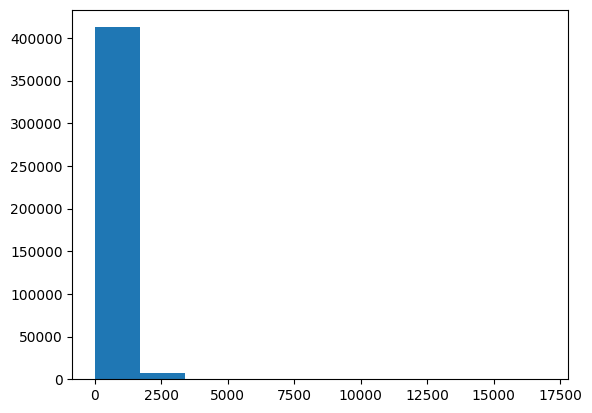

In [ ]:
plt.hist(char_list)

Podobnie jak wcześniej tylko że tu sprawdzamy nie ilość wyrazów w zdaniu a ilośc pojedynczych liter . Na tym właśnie polega kodowanie nie za pomocą wyrazów a znaków `char_embed`

In [ ]:
char_seq = int(np.percentile(char_list, 95))
char_seq

1183

In [ ]:
import string as str
alphabet = str.ascii_lowercase + str.digits + str.punctuation
NUM_CHAR_TOKENS = len(alphabet) + 2
NUM_CHAR_TOKENS

70

Określam pełen zestaw możliwych znaków: litery, cyfry, znaki interpunkcyjne.

Dodaję dwa specjalne tokeny: [UNK] (nieznany znak) i [PAD] (dopełnienie).

In [ ]:
char_vectorizer = TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_mode='int',
    output_sequence_length=char_seq
)  # sequence_len = 215



In [ ]:
x = 100 * ['d d d d ', 'd d d d d d ', 'd d d dd d ']

In [ ]:
#
import pandas as pd
subset = pd.DataFrame(train_chars).sample(frac=0.05, random_state=42)
subset.columns = ['val']
subset
subset = subset['val'].to_list()

In [ ]:
char_vectorizer.adapt(subset)

In [ ]:
len(char_vectorizer.get_vocabulary())

48

In [ ]:
char_embed = Embedding(
  input_dim=NUM_CHAR_TOKENS,
  output_dim=28,
  embeddings_initializer='uniform'
)

# char_vectorizer + char_embed + Conv1D

# Zamysł modelu 3

Model model_3 jest zaprojektowany do pracy z tekstami na poziomie znaków zamiast na poziomie słów. Oznacza to, że model nie analizuje pojedynczych słów, ale rozkłada tekst na pojedyncze znaki, takie jak litery, cyfry, interpunkcje i inne znaki. To podejście może być szczególnie użyteczne w sytuacjach, gdy teksty zawierają błędy ortograficzne, slang, nieznane słowa lub emotikony.

# Poziomy modelu

- Preprocessing (wejściowe dane) – char_vectorizer

 Zadanie: Każdy tekst jest rozdzielany na pojedyncze znaki, a te znaki są następnie konwertowane na numeryczne reprezentacje. Używamy TextVectorization, by zamienić każdy znak na jego unikalny identyfikator.

 Działanie: Zamiast tokenizować teksty na słowa, model tokenizuje na znaki. Np. zdanie "hello" stanie się ["h", "e", "l", "l", "o"], a następnie te znaki są reprezentowane przez odpowiednie numeryczne identyfikatory.

- Embedding – char_embed

 Zadanie: Po przekształceniu znaków na numeryczne tokeny, embedding je przekształca w wektory o stałej długości (np. 28 wymiarów). Celem tej warstwy jest przekształcenie surowych tokenów w gęste reprezentacje numeryczne, które zawierają semantyczne informacje o znakach.

 Działanie: Jeśli np. znak 'h' ma token 2, to zostanie przekształcony w wektor o wymiarach 28, który jest uczoną reprezentacją tego znaku.

- Warstwa konwolucyjna (CNN) – Conv1D

 Zadanie: Warstwa konwolucyjna służy do wykrywania lokalnych wzorców w sekwencji znaków. Na przykład, może wykrywać zakończenia słów, powtarzające się sekwencje, czy inne zależności w obrębie tekstu.

 Działanie: Filtry konwolucyjne "przesuwają się" po sekwencji wektorów znaków i uczą się wykrywać wzorce, które są istotne dla klasyfikacji tekstu (np. zakończenia słów, emotikony). Filtry mają rozmiar 5, co oznacza, że patrzą na sekwencje 5 znaków w jednym czasie.

- GlobalAveragePooling1D

 Zadanie: Agreguje informacje z całej sekwencji, aby uzyskać jedno wektoryzowane podsumowanie tekstu.

 Działanie: Warstwa ta redukuje dane z całej sekwencji wyjść z Conv1D do jednego wektora. Pomaga to w uzyskaniu stałej długości reprezentacji tekstu, bez względu na jego długość.

- Warstwa Dense i wyjście

 Zadanie: Ostateczna warstwa Dense(1, activation='sigmoid') jest odpowiedzialna za klasyfikację binarną. Na przykład, model może klasyfikować teksty jako pozytywne/negatywne, spam/nie-spam, itp.

 Działanie: Model uzyskuje jedno wyjście, które jest interpretowane jako prawdopodobieństwo jednej z dwóch klas (np. 0 = negatywne, 1 = pozytywne).

In [ ]:
import tensorflow as tf
inputs = tf.keras.layers.Input(shape=(1, ), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
print(x.shape)
x = tf.keras.layers.Conv1D(64, 5, activation='relu')(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
print(x.shape)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model_3 = tf.keras.Model(inputs, outputs)


(None, 1183, 28)
(None, 64)


In [ ]:
model_3.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,y_test)).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:

model_3.fit(
    train_char_dataset,
    validation_data=val_char_dataset,
    steps_per_epoch=int(0.15 * len(train_char_dataset)),
    validation_steps=int(0.15 * len(val_char_dataset)),
    epochs=3,
    class_weight=class_weights
)

Epoch 1/3
1971/1971 [==============================] - 168s 85ms/step - loss: 0.6788 - accuracy: 0.6326 - val_loss: 0.7393 - val_accuracy: 0.5232
Epoch 2/3
1971/1971 [==============================] - 168s 85ms/step - loss: 0.6547 - accuracy: 0.6664 - val_loss: 0.5939 - val_accuracy: 0.7456
Epoch 3/3
1971/1971 [==============================] - 178s 90ms/step - loss: 0.6528 - accuracy: 0.6665 - val_loss: 0.6221 - val_accuracy: 0.7033


In [ ]:
model_preds_3 = model_3.predict(val_char_dataset)
model_preds_3

3287/3287 [==============================] - 75s 23ms/step


array([[0.5008044 ],
       [0.6032994 ],
       [0.50822085],
       ...,
       [0.66836697],
       [0.52723515],
       [0.6767891 ]], dtype=float32)

In [ ]:
model_preds_3 = tf.squeeze(tf.round(model_preds_3))
model_preds_3

<tf.Tensor: shape=(105163,), dtype=float32, numpy=array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)>

In [ ]:
model_3_results = calculate_results(
    y_true=y_test,
    y_pred=model_preds_3
)

model_3_results

{'accuracy': 69.9704268611584,
 'precision': 0.8010270280795575,
 'recall': 0.699704268611584,
 'f1': 0.7351231806660354}

In [ ]:
# token model
token_input = tf.keras.layers.Input(shape=[], dtype=tf.string)
x = tf_hub_sentence_encoder(token_input)
token_output = tf.keras.layers.Dense(128, activation='relu')(x)
token_model = tf.keras.Model(token_input, token_output)

# char model
char_input = tf.keras.layers.Input(shape=(1, ), dtype=tf.string)
x = char_vectorizer(char_input)
x = char_embed(x)
bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
char_model = tf.keras.Model(char_input, bi_lstm)

# Concatanate
token_char_concat = tf.keras.layers.Concatenate()([token_model.output, char_model.output])
combined_dropout = tf.keras.layers.Dropout(0.3)(token_char_concat)
combined_dense = tf.keras.layers.Dense(256, activation='relu')(combined_dropout)
final_dropout = tf.keras.layers.Dropout(0.3)(combined_dense)
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(final_dropout)
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer)

model_4.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Dropout, Dense, Dropout, Dense

#  Zamysł modelu 4

Ten model łączy dwa komplementarne podejścia do przetwarzania języka naturalnego:

- Semantyka całych zdań (token-level) – token_model
Wykorzystuje Universal Sentence Encoder (USE) z TensorFlow Hub, który przekształca całe zdania w wektory semantyczne.

 Dzięki temu model rozumie kontekst i sens zdania jako całości – to tzw. embedding na poziomie zdań.

- Struktura tekstu na poziomie znaków (char-level) – char_model
 Przetwarza tekst znak po znaku, wykorzystując TextVectorization, embeddingi znakowe i warstwę BiLSTM.

 Pozwala modelowi wychwycić drobne detale, takie jak:

 - styl pisania,

 - błędy ortograficzne,

 - skróty, slang, emotikony,

 - pisownię charakterystyczną dla emocji (np. "loooove", "!!!", "suuuper").



In [ ]:
train_char_token_dataset = tf.data.Dataset.from_tensor_slices((X_train, train_chars))
train_char_token_label = tf.data.Dataset.from_tensor_slices((y_train))
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_dataset, train_char_token_label))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_char_token_dataset = tf.data.Dataset.from_tensor_slices((X_test, val_chars))
val_char_token_label = tf.data.Dataset.from_tensor_slices((y_test))
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_dataset, val_char_token_label))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_4.fit(
    train_char_token_dataset,
    validation_data=val_char_token_dataset,
    steps_per_epoch=int(0.03 * len(train_char_token_dataset)),
    validation_steps=int(0.03 * len(val_char_token_dataset)),
    epochs=3,
    class_weight=class_weights
)

Epoch 1/3
394/394 [==============================] - 648s 2s/step - loss: 0.3945 - accuracy: 0.8347 - val_loss: 0.3900 - val_accuracy: 0.8198
Epoch 2/3
394/394 [==============================] - 626s 2s/step - loss: 0.3247 - accuracy: 0.8585 - val_loss: 0.3104 - val_accuracy: 0.8591
Epoch 3/3
394/394 [==============================] - 636s 2s/step - loss: 0.3104 - accuracy: 0.8623 - val_loss: 0.4084 - val_accuracy: 0.8138


# Generowanie podsumowań:

poniżej stosuje gotowe metody do tworzenia inteligentnych podsumowań na podstawie dłuższych tekstów


In [ ]:
df[['Text', 'Summary']].dropna().head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [ ]:
# 1. Instalacja transformers (jeśli nie masz)
# !pip install transformers datasets -q
# 2. Importy
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset

In [ ]:
# 3. Tokenizer i model
model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name) # ładuje tokenizer odpowiadający modelowi t5
model = T5ForConditionalGeneration.from_pretrained(model_name) # ładuje sam model

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:

# 4. Wczytaj dane Amazon

# 5. Przykładowe ograniczenie do mniejszych danych do testów (np. 1000)
df = df.dropna(subset=["Text", "Summary"])
df = df[df["Summary"].str.strip().astype(bool)]  # usuwa puste streszczenia
texts = df["Text"].tolist()[:100]
summaries = df["Summary"].tolist()[:100]

# Funkja preprocess
To funkcja, która:

Przygotowuje dane wejściowe (teksty) i docelowe (streszczenia) dla modelu.

Używa tokenizera (np. T5Tokenizer), by zamienić teksty na tokeny liczbowo

In [ ]:
# 6. Preprocessing
def preprocess(texts, summaries, tokenizer, max_input_length=512, max_target_length=64):
    inputs = ["summarize: " + text for text in texts] # prefiks potrzebny żeby model skumał że ma zrobić streszczenie
    model_inputs = tokenizer(
        inputs,
        max_length=max_input_length, # ucinanie do 512 tokenów
        truncation=True, # przycinanie tekstu
        padding="max_length", # jesli za krotki do rozszerza do 512
        return_tensors="pt"
    )
    labels = tokenizer(
        summaries, max_length=max_target_length, truncation=True, padding="max_length", return_tensors="pt"
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
# 7. Dataset klasa
class SummarizationDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings # __init__ – zapamiętuje zakodowane dane (inputy i etykiety).
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()} # __getitem__ – zwraca pojedyńczy przykład (np. 0, 1, 2…) jako słownik: input_ids, attention_mask, labels.
    def __len__(self):
        return len(self.encodings["input_ids"]) # __len__ – zwraca ile jest przykładów w całym zbiorze.

In [ ]:
# 8. Przygotowanie danych
data_encodings = preprocess(texts, summaries, tokenizer)
dataset = SummarizationDataset(data_encodings)

In [ ]:

import os
os.environ["WANDB_DISABLED"] = "true" # nie pytaj o klucz API
# 9. Argumenty treningu
training_args = TrainingArguments(
    output_dir="./results", # gdzie zapisac logi po treningu
    per_device_train_batch_size=4, # batch
    num_train_epochs=3, #
    logging_dir="./logs"  # gdzie zapisać logi np. do TensorBoard
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
# 10. Trener
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)

In [ ]:
# obiekt Trainer, który trenuje model:
# na zbiorze dataset,
# zgodnie z Argumentami treningu

# 11. Trening - rozpoczyna trenowanie modelu na moich danych
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss


TrainOutput(global_step=75, training_loss=5.034991861979167, metrics={'train_runtime': 708.7099, 'train_samples_per_second': 0.423, 'train_steps_per_second': 0.106, 'total_flos': 40602540441600.0, 'train_loss': 5.034991861979167, 'epoch': 3.0})

In [ ]:
# 12. Funkcja do streszczenia
def summarize(text):
    input_ids = tokenizer("summarize: " + text, return_tensors="pt", truncation=True, max_length=512).input_ids
    output_ids = model.generate(input_ids, max_length=64, num_beams=4, early_stopping=True)  # generuje streszczenie , num_beams = lepsze streszczenie, max_length - długość streszczenia
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)  # zmienia tokeny z powrotem na tekst , output_ids[0] bo może lista , skip pomija jakies pierdoly typu <>

# 13. Przykład użycia
# print(summarize("Ten telefon jest szybki, ma dobry ekran i trzyma baterię dwa dni."))

ten telefon jest szyb.


# Przykład
- lekko ucina, tak jakby faktycznie robiło streszczenie

In [ ]:
print(summarize("I am very satisfied ,product is as advertised, I use it on cereal, with raw vinegar, and as a general sweetner."))

i am very satisfied,product is as advertised, I use it on cereal.


# KMeans

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
texts = df["Text"].dropna().tolist()

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')  # 1000 najczestrzych slow , usuwa słowa typu `the`, `is`
X = vectorizer.fit_transform(X_train)

In [ ]:
k = 5
kmeans = KMeans(
    n_clusters=k,
    random_state=42
)

In [ ]:
kmeans.fit(X)

KMeans(n_clusters=5, random_state=42)

In [ ]:
terms = vectorizer.get_feature_names_out() # pobiera liste wszystkich słów jakie TfVectorizer zidentyfikował

In [ ]:
len(terms)

1000

In [ ]:
# kmeans.cluster_centers_ – to macierz [k × n_features], gdzie każdy wiersz to „średni wektor” klastra

In [ ]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1] # zwraca indeksy słów, posortowane wg ważności (na podstawie wagi TF-IDF) dla każdego tematu.
# .argsort() – zwraca indeksy słów, posortowane wg ważności (na podstawie wagi TF-IDF) dla każdego
# [:, ::-1] -  odwraca kolejność, by mieć najważniejsze słowa na początku.

In [ ]:
order_centroids

array([[172, 220, 487, ..., 922, 462, 252],
       [100, 487, 371, ..., 382, 269, 265],
       [380, 371, 689, ..., 970, 760, 462],
       [885, 381, 100, ..., 454, 462, 631],
       [255, 336, 915, ..., 288, 461, 528]])

In [ ]:
# 10 najbardziej reprezentatywnych słów

for i in range(k):
    print(f"Temat {i + 1}:")
    for ind in order_centroids[i, :10]:
        print(" ", terms[ind])
    print()


Temat 1:
  coffee
  cup
  like
  flavor
  strong
  cups
  good
  br
  taste
  great

Temat 2:
  br
  like
  good
  product
  just
  taste
  flavor
  great
  amazon
  don

Temat 3:
  great
  good
  product
  like
  taste
  love
  just
  flavor
  amazon
  best

Temat 4:
  tea
  green
  br
  teas
  flavor
  like
  drink
  good
  taste
  love

Temat 5:
  dog
  food
  treats
  dogs
  cat
  loves
  cats
  treat
  br
  love



In [ ]:
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8742427 stored elements and shape (420651, 1000)>

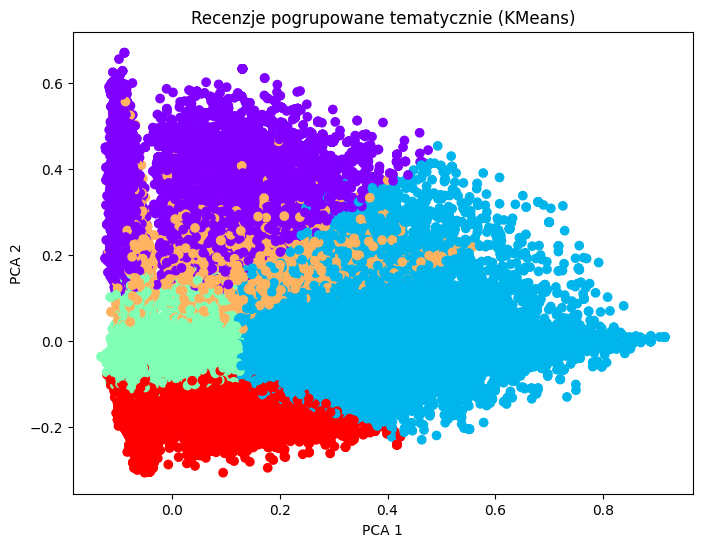

In [ ]:
pca = PCA(n_components=2)    # redukcja wymiarowości
X_2d = pca.fit_transform(X.toarray())   # X.toarray() konwersja z macierzy sparse do numpy , oblicza PCA i zwraca dane w 2D
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans.labels_, cmap='rainbow') # kmeans.labels_  - każdy punkt ma kolor odpowiadający klastrowi
plt.title("Recenzje pogrupowane tematycznie (KMeans)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()